In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import cv2

In [2]:
from os import listdir

# Set the src as the folder which contains the dataset DS
src = "C:/Users/srush/Documents/Python/Assignment3_1102484"

images = list()
classLabel = list()
for imagename in listdir(src+'/DS/'):
    classLabel.append(imagename.split('_')[0])
    # load image
    img = cv2.imread(src + '/DS/' + imagename)
    # Resize and store loaded image
    imgnew = cv2.resize(img,(32,32))
    images.append(imgnew)

In [3]:
images = np.array(images, dtype = 'float64')

In [4]:
# Splitting training and testing of the numpy array of images
from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(images, test_size=0.20, random_state=42)
y_train, y_test = train_test_split(classLabel, test_size=0.20, random_state=42)

In [5]:
# Creating a directory for storing the images for training set for data augmentation

trainDir = src + '/trainfolder/train'
if os.path.exists(trainDir):
    print('Deleted exisitng folder')
    shutil.rmtree(trainDir)

os.makedirs(trainDir)

In [6]:
# Getting random images for storing it in the training folder created

imageNames = os.listdir(src+'/DS')
np.random.shuffle(imageNames)
trainImages, testImages = np.split(np.array(imageNames),[int(len(imageNames)*0.8)])

trainFiles = [src+'/DS/'+ file for file in trainImages.tolist()]

In [7]:
# Copying images in the training folder
for file in trainFiles:
    shutil.copy(file, "trainfolder/train")

In [8]:
# Using image generator for data augmentation on the training set

from tensorflow.keras.preprocessing.image import ImageDataGenerator  

trainImageGen = ImageDataGenerator(rescale=1./255)
train_augData = trainImageGen.flow_from_directory(
        directory=src + '/trainfolder',
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')


Found 1200 images belonging to 1 classes.


In [9]:
# Creating CNN model for feature extraction

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization


# CNN MODEL CREATION

modelCNN = Sequential()

# Model with 2 convolution layers and 3 fully connected layers
modelCNN.add(Conv2D(filters=64,kernel_size=3,activation='relu',input_shape = (32,32,3)))
modelCNN.add(BatchNormalization())
modelCNN.add(MaxPooling2D(pool_size=2))
modelCNN.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
modelCNN.add(BatchNormalization())
modelCNN.add(MaxPooling2D(pool_size=2))
modelCNN.add(Flatten())
modelCNN.add(Dense(10, activation='relu'))
modelCNN.add(Dense(10, activation='relu'))
modelCNN.add(Dense(1))

# Using adam as optimizer 
modelCNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])



In [10]:
# Training the CNN model on augmented training dataset

modelCNN.fit(train_augData)

Train for 38 steps
38/38 [==============================] - 7s 174ms/step - loss: nan - accuracy: 0.0000e+00


In [11]:
from tensorflow.keras.models import load_model
#modelCNN.save('my_modelCNN_1102484.h5')  # creates a HDF5 file 'my_model.h5'
modelCNN = load_model('my_modelCNN_1102484.h5')

In [12]:
# Extracting the model till second last layer for feature extraction

from tensorflow import keras

extractedModel = keras.Model(inputs=modelCNN.inputs, outputs=modelCNN.layers[8].output)
extractedModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0     

In [13]:
X_train, X_test = train_test_split(images, test_size=0.20, random_state=42)
y_train, y_test = train_test_split(classLabel, test_size=0.20, random_state=42)

In [14]:
# Extracting the training and testing features from the CNN model extracted

trainingFeatures = np.array(extractedModel(X_train))
testingFeatures = np.array(extractedModel(X_test))

In [15]:
trainingFeatures

array([[ 6.118051,  0.      ,  0.      , ..., 17.328108,  0.      ,
         0.      ],
       [ 4.996817,  0.      ,  0.      , ..., 14.65056 ,  0.      ,
         0.      ],
       [25.764708,  0.      ,  0.      , ..., 33.874535, 16.728836,
        30.921965],
       ...,
       [ 4.554864,  0.      ,  0.      , ..., 14.607115,  0.      ,
         0.      ],
       [11.474921,  0.      ,  0.      , ..., 22.744444, 12.650901,
        32.139294],
       [ 8.115867,  0.      ,  0.      , ..., 24.057217, 12.289771,
        22.341087]], dtype=float32)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

Text(0, 0.5, 'Error Rate')

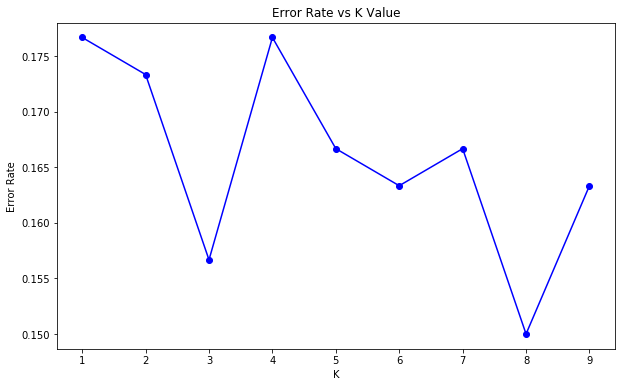

In [17]:
# Function to show error rate for different values of k before chosing optimal k value

error = []

for i in range(1,10):
    knnModel = KNeighborsClassifier(n_neighbors=i)
    knnModel.fit(trainingFeatures,y_train)
    predict = knnModel.predict(testingFeatures)
    error.append(np.mean(predict != y_test))
    

# Plotting the error rate for different values of k
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error,color='blue',marker='o')
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [18]:
# Training KNN model with optimal value of k

knnModel = KNeighborsClassifier(n_neighbors=3)

knnModel.fit(trainingFeatures,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [19]:
# Saving and loading the trained KNN model

import pickle

#pickle.dump(knnModel, open('1102484_KNN.pkl', 'wb'))
knnModel = pickle.load(open('1102484_KNN.pkl', 'rb'))

In [20]:
# Function to predict using the saved or trained KNN model
from sklearn.metrics import classification_report,confusion_matrix

predictionsKNN = knnModel.predict(testingFeatures)

print("Confusion Matrix for KNN:\n")
print(confusion_matrix(y_test,predictionsKNN))

print("\nClassification Report for KNN:\n")
print(classification_report(y_test,predictionsKNN))

Confusion Matrix for KNN:

[[ 76  28   0]
 [ 18  68   0]
 [  1   0 109]]

Classification Report for KNN:

              precision    recall  f1-score   support

     Abdomen       0.80      0.73      0.76       104
       Chest       0.71      0.79      0.75        86
        Head       1.00      0.99      1.00       110

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.85      0.84      0.84       300



In [21]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Function to show hyper parameter tuning for random forest

errorForDifferentN = []

# Determining error rate for different values (100-150) of n_estimator
for i in range(100,200):
    randomForestModel1 = RandomForestClassifier(n_estimators=i,max_features='sqrt')
    randomForestModel1.fit(trainingFeatures,y_train)
    predict1 = randomForestModel1.predict(testingFeatures)
    errorForDifferentN.append(np.mean(predict1 != y_test))
    
    
# Determining error rate for different values (50,100) of max_depth
errorForDifferentMaxFeatures = []
for i in range(10,100):
    randomForestModel2 = RandomForestClassifier(n_estimators=132,max_depth=i)
    randomForestModel2.fit(trainingFeatures,y_train)
    predict2 = randomForestModel2.predict(testingFeatures)
    errorForDifferentMaxFeatures.append(np.mean(predict2 != y_test))
    
# Plotting the error rate for different values of hyperparameters  
plt.figure(figsize=(15,5))

# Plotting for different values of n_estimators
plt.subplot(1,2,1)
plt.plot(range(100,200),errorForDifferentN,color='blue',marker='o')
plt.title('Error Rate vs n-estimator Values')
plt.xlabel('N')
plt.ylabel('Error Rate')


# Plotting for different values of max_features
plt.subplot(1,2,2)  
plt.plot(range(10,100),errorForDifferentMaxFeatures,color='red',marker='o')
plt.title('Error Rate vs max_depth Value')
plt.xlabel('Maximum depth of the tree')
plt.ylabel('Error Rate')

plt.show()

In [ ]:
# HYPERPARAMETER TUNING USING RANDOM SEARCH

n_estimators = [100,110,120,130,140,150,160,170,180,190,200]
max_depth = [10,20,30,40,50,60,70,80,90,100]
bootstrap = [True, False]

hyperParameterGrid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'bootstrap': bootstrap}

print(hyperParameterGrid)

In [ ]:
# Function to train using random search

from sklearn.model_selection import RandomizedSearchCV

RFModel_RandomSearch = RandomForestClassifier()

randomSearchModel = RandomizedSearchCV(estimator = RFModel_RandomSearch, param_distributions = hyperParameterGrid, n_iter = 10, cv = 3, verbose=2, random_state=101)
randomSearchModel.fit(trainingFeatures, y_train)

In [ ]:
print("Best parameters selected for RF: \n")
print(randomSearchModel.best_params_)

In [ ]:
# Function to evaluate the base model and model with tuned hyper-parameters

def predict(model,testFeatures, y_test):
    predictions = model.predict(testFeatures)
    errorPercent = 100 * np.mean(predictions != y_test)
    accuracy = 100 - errorPercent
    return accuracy
    
# Prediction with base model
randomForestModel_Base = RandomForestClassifier(n_estimators = 5, random_state = 44)
randomForestModel_Base.fit(trainingFeatures, y_train)
accuracy1 = predict(randomForestModel_Base, testingFeatures, y_test)
print("Accuracy for base RF model: ",accuracy1,"%")
 
# Prediction with model considering best hyper=parameters
randomForestModel = randomSearchModel.best_estimator_
accuracy2 = predict(randomForestModel, testingFeatures, y_test)
print("Accuracy for RF model with best parameters: ",accuracy2,"%")

In [ ]:
# Saving and loading the trained Random Forest model

import pickle

#pickle.dump(randomForestModel_Best, open('1102484_RF.pkl', 'wb'))
randomForestModel = pickle.load(open('1102484_RF.pkl', 'rb'))

In [ ]:
# Function to predict using the saved or trained random forest model
from sklearn.metrics import classification_report,confusion_matrix

predictionsRF = randomForestModel.predict(testingFeatures)

print("Confusion Matrix for Random Forest:\n")
print(confusion_matrix(y_test,predictionsRF))

print("Classification Report for Random Forest:\n")
print(classification_report(y_test,predictionsRF))